In [1]:
import os
import sys
import numpy as np
import pandas as pd

IMATOOLS_DIR = os.getcwd()+'/..'
sys.path.insert(1, IMATOOLS_DIR)

from imatools.common import vtktools as vtku
from imatools.common import ioutils as iou

def calc_cog(pts, el):
    return [np.mean(pts[ee], 0) for ee in el]


def norm2(a): return np.linalg.norm(a)
def norm_vec(a): return a/norm2(a)


def remove_from_dirlist(dir_list, name_to_rm):
    if name_to_rm in dir_list:
        dir_list.remove(name_to_rm)

    return dir_list

def perc_above(arr, th) : 
    return np.sum(arr>th) / len(arr)

def perc_below(arr, th) : 
    return np.sum(arr<th) / len(arr)


# Locations of hard drive based on platform
dirdic = {'macOS': '/Volumes/sandisk',
          'Linux': '/media/jsl19/sandisk',
          'Windows': 'D:/'}

tex_dic = {'macOS': '/Users/jsolislemus/Documents/TEX',
           'Linux': '/home/jsl19/Documents/tex'}

base_dir = iou.fullfile(dirdic[iou.chooseplatform()], '01_atrialfibres/06_Reproducibility/05_UserProjects')
comp_dir = iou.fullfile(base_dir, '011_comparisons')

ld = remove_from_dirlist(os.listdir(iou.fullfile(comp_dir,'C0')), 'COMPARISONS')
ld = remove_from_dirlist(ld, 'MAPPING')

CX = ['C' + str(n) for n in np.linspace(0,49,num=50, dtype=int)]

print(ld)

['M1', 'M2']


# Preliminaries: 
+ Get comparison paths and create the `processing` and `mode` lists
+ Create local_cv files using the `gradlat` files 

In [77]:
df_comp = pd.read_csv(iou.fullfile(comp_dir, 'comparisons_path.csv'))
mode = df_comp['mode']
mode = mode[np.linspace(0,98,num=50, dtype=int)]

processing_raw = df_comp['processing'].tolist()
processing_raw = [processing_raw[ix] + processing_raw[ix+1] for ix in range(50)]

a='automatic'
m='manual'

processing = [p.replace(a+a, a) for p in processing_raw]
processing = [p.replace(m+m, m) for p in processing]
processing = [p.replace(a+m, 'mixed') for p in processing]
processing = [p.replace(m+a, 'mixed') for p in processing]

files_and_mapping = {
    'lat': ('LAT_RSPV_X.dat', 'fibre_X_pts.csv'),
    'cv': ('local_cv_X.dat', 'fibre_X_pts.csv'),
    'gradlat': ('lat_X.gradmag.dat', 'fibre_X_pts.csv'),
    'ps': ('PSNodeSmooth.dat', 'input_pts.csv'),
    'f_endo': ('fibre_X_endo.lon', 'fibre_X_endo_elem.csv'),
    'f_epi': ('fibre_X_epi.lon', 'fibre_X_epi_elem.csv')
}

print(len(mode))
print(len(processing))

['mixed',
 'automatic',
 'automatic',
 'automatic',
 'automatic',
 'mixed',
 'manual',
 'manual',
 'manual',
 'manual',
 'mixed',
 'automatic',
 'automatic',
 'automatic',
 'mixed',
 'mixed',
 'automatic',
 'automatic',
 'automatic',
 'mixed',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'mixed',
 'mixed',
 'manual',
 'manual',
 'manual',
 'manual',
 'mixed',
 'automatic',
 'automatic',
 'automatic',
 'automatic',
 'automatic',
 'mixed',
 'manual',
 'manual',
 'manual',
 'manual',
 'manual',
 'mixed',
 'automatic',
 'automatic',
 'automatic',
 'mixed']

Create comparison list

In [3]:
if iou.chooseplatform() == 'Linux':
    comparison_list = [c.replace('/Volumes', '/media/jsl19')
                       for c in df_comp['comparison_path'].tolist()]
else:
    comparison_list = df_comp['comparison_path'].tolist()
cx = 0  # go in even numbers!
import scipy.stats as sstat

def cname(dx, mx) : 
    return dx + '_' + mx + '.csv' 
comp_a = comparison_list[cx]
comp_b = comparison_list[cx+1]


## Create local cv
Create `local_cv_X.dat` files with the reciprocal of each `gradlat_X.dat`

In [4]:
dx = 'gradlat'
mmxx = ['1', 'l'] 

mx = mmxx[0]

for c in comparison_list : 
    for mx in mmxx : 
        fname = files_and_mapping[dx][0].replace('X', mx)
        gradlat = np.loadtxt(iou.fullfile(c, fname))
        qrts = iou.get_boxplot_values(gradlat)
        gradlat[gradlat < qrts['low_whisker']] = np.nan
        lcv = 1/gradlat
        
        np.savetxt(iou.fullfile(c, 'local_cv_' + mx + '.dat'), lcv)

iou.cout('Finished')

[INFO] Finished


In [93]:
cx = 0
dx = 'cv'
mx = 'l'

iou.fullfile(comparison_list[cx+1], files_and_mapping[dx][0].replace('X', mx))


'/media/jsl19/sandisk/01_atrialfibres/06_Reproducibility/05_UserProjects/011_comparisons/C0/M2/local_cv_l.dat'

{'min': 239.8305836756915, 'low_whisker': 239.8305836756915, 'low_quartile': 619.248727443865, 'median': 730.7163943530237, 'high_quartile': 876.3704242509223, 'high_whisker': 1262.0529694615082, 'max': 2344.94628900525}


<AxesSubplot:>

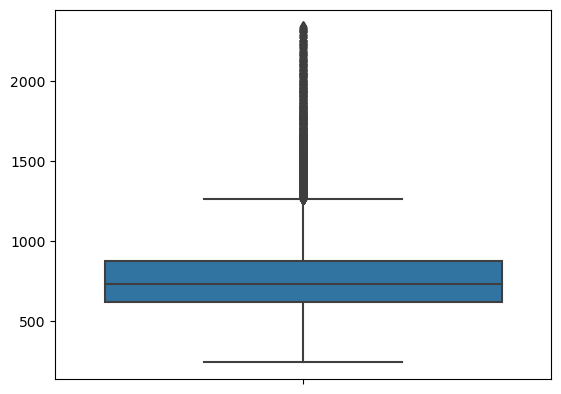

In [6]:
import seaborn as sns

dx = 'cv'
mx = 'l'

cx = 4
comp_a = iou.fullfile(comparison_list[cx], files_and_mapping[dx][0].replace('X', mx))
comp_b = iou.fullfile(comparison_list[cx+1], files_and_mapping[dx][0].replace('X', mx))

f_a = np.loadtxt(comp_a)
f_b = np.loadtxt(comp_b)

print(iou.get_boxplot_values(f_a))
sns.boxplot(y=f_a)


In [18]:
import scipy.stats as sstat

def cname(dx, mx) : 
    return dx + '_' + mx + '.csv' 

dx = 'lat'
mx = 'l'

cx = 0
comparison_file = iou.fullfile(comp_dir, CX[cx], 'COMPARISONS', cname(dx, mx))

df = pd.read_csv(comparison_file, skipinitialspace=True)



comp_a = iou.fullfile(comparison_list[cx], files_and_mapping[dx][0].replace('X', mx))
comp_b = iou.fullfile(comparison_list[cx+1], files_and_mapping[dx][0].replace('X', mx))

f_a = np.loadtxt(comp_a)
f_b = np.loadtxt(comp_b)

TAT = lambda x : np.nanmax(x) - np.nanmin(x)
print('A: {}, B: {}, diff : {}'.format(TAT(f_a), TAT(f_b), TAT(f_a)-TAT(f_b)))

print(np.corrcoef(df['lat_0'], df['lat_1']))

ss = sstat.pearsonr(df['lat_0'], df['lat_1'])

# ss.statistic
# sns.lmplot(data=df.sample(1000), x='lat_0', y='lat_1')

df

A: 143.6578, B: 137.4167, diff : 6.241100000000017
[[1.         0.96529684]
 [0.96529684 1.        ]]


,diff_square,diff_abs,lat_0,lat_1,distance
0,576.148810,24.0031,104.6860,80.6829,0.061969
1,588.702874,24.2632,104.5950,80.3318,0.190832
2,590.694138,24.3042,104.7080,80.4038,0.172751
3,583.029316,24.1460,104.7450,80.5990,0.114740
4,580.916045,24.1022,104.7820,80.6798,0.135512
...,...,...,...,...,...
262876,275.261281,16.5910,130.4290,113.8380,0.453934
262877,284.195536,16.8581,108.1070,91.2489,0.210283
262878,412.455481,20.3090,133.6850,113.3760,0.356253
262879,296.869454,17.2299,111.1130,93.8831,0.097240


### LAT Comparisons
1. Pairwise correlation coefficient (from mapping data)
2. Total activation time for each, then ranksum or ttest 

|     | Correlation | p-val | total activation (MX) | total activation (MY) | abs(diff) | mode  | processing |    fibre   |
|-----|-------------|-------|-----------------------|-----------------------|-----------|-------|------------|------------|
| C0  |             |       |                       |                       |           | inter | mixed      |      1     |
| C0  |             |       |                       |                       |           | inter | automatic  |      l     |
| C1  |             |       |                       |                       |           | inter | automatic  |      1     | 
| ... |             |       |                       |                       |           | ...   | ...        |     ...    |
| C49 |             |       |                       |                       |           | intra | manual     |      l     | 

In [78]:
import scipy.stats as sstat

def cname(dx, mx) : 
    return dx + '_' + mx + '.csv' 

TAT = lambda x : np.nanmax(x) - np.nanmin(x)

subsample = 0.30

dx = 'lat'
fibre_files = ['1', 'l']
keys = ['correlation', 'corr_p_val', 'tat_a', 'tat_b', 'abs_diff', 'mode', 'processing', 'fibre' ]
midic = dict.fromkeys(keys)

midic['correlation'] = np.zeros(len(CX)*2)
midic['corr_p_val'] = np.zeros(len(CX)*2)
midic['tat_a'] = np.zeros(len(CX)*2)
midic['tat_b'] = np.zeros(len(CX)*2)
midic['fibre'] = ['1', 'l']*50
midic['mode'] = df_comp['mode'].tolist()
midic['processing'] = np.repeat(processing,2)


for cx in range(len(CX)) : 
    for fx in range(len(fibre_files)) :
        
        comparison_file = iou.fullfile(comp_dir, CX[cx], 'COMPARISONS', cname(dx, fibre_files[fx]))
        df = pd.read_csv(comparison_file, skipinitialspace=True).sample(frac=subsample)
        A = df[dx+'_0']
        B = df[dx+'_1']
        ss = sstat.pearsonr(x=A, y=B)

        idx = 2*cx + fx 

        midic['correlation'][idx] = ss.statistic
        midic['corr_p_val'][idx] = ss.pvalue
        midic['tat_a'][idx] = TAT(A)
        midic['tat_b'][idx] = TAT(B)

midic['abs_diff'] = np.abs(midic['tat_a'] - midic['tat_b'])


df_lat = pd.DataFrame(midic)


<AxesSubplot:xlabel='mode', ylabel='correlation'>

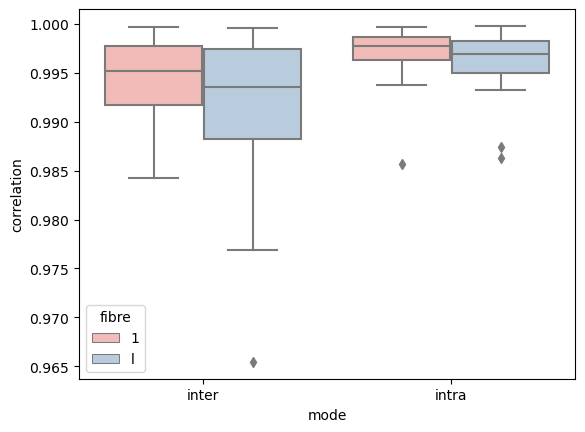

In [91]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# sm.graphics.mean_diff_plot(df_lat['tat_a'], df_lat['tat_b'])
sns.set_palette('Pastel1')
sns.boxplot(data=df_lat, x='mode', y='correlation', hue='fibre')


### CV Comparisons
1. Get boxplot quartiles per observation
2. Include 
3. Build table 
   
|     | Corr (p-val) | A: median (+/- IQR) | B: median (+/- IQR) | ranksum p-val | mode  | processing |    fibre   |
|-----|--------------|---------------------|---------------------|---------------|-------|------------|------------|
| C0  | corr (p)     | m (+/- IQR)         | m (+/- IQR)         | p             | inter | mixed      |      1     |
| C0  | corr (p)     | m (+/- IQR)         | m (+/- IQR)         | p             | inter | mixed      |      l     |
| ... | ...          | ...                 | ...                 | ...           | ...   | ...        |     ...    |
| C30 | corr (p)     | m (+/- IQR)         | m (+/- IQR)         | p             | intra | automatic  |      1     |
| ... | ...          | ...                 | ...                 | ...           | ...   | ...        |     ...    |

In [133]:
import scipy.stats as sstat


def cname(dx, mx):
    return dx + '_' + mx + '.csv'


def TAT(x): return np.nanmax(x) - np.nanmin(x)


subsample = 0.30

dx = 'gradlat'
fibre_files = ['1', 'l']
keys = ['correlation', 'corr_p_val', 'median_a', 'iqr_a',
        'median_b', 'iqr_b', 'ranksum_p_val', 
        'mode', 'processing', 'fibre']
midic = dict.fromkeys(keys)

midic['correlation'] = np.zeros(len(CX)*2)
midic['corr_p_val'] = np.zeros(len(CX)*2)
midic['median_a'] = np.zeros(len(CX)*2)
midic['iqr_a'] = np.zeros(len(CX)*2)
midic['median_b'] = np.zeros(len(CX)*2)
midic['iqr_b'] = np.zeros(len(CX)*2)
midic['ranksum_p_val'] = np.zeros(len(CX)*2)
midic['fibre'] = ['1', 'l']*50
midic['mode'] = df_comp['mode'].tolist()
midic['processing'] = np.repeat(processing, 2)


for cx in range(len(CX)):
    for fx in range(len(fibre_files)):

        comparison_file = iou.fullfile(
            comp_dir, CX[cx], 'COMPARISONS', cname(dx, fibre_files[fx]))
        df = pd.read_csv(comparison_file, skipinitialspace=True).sample(frac=subsample).reset_index()
        A = 1/df[dx+'_0']
        B = 1/df[dx+'_1']

        ix_a = A[A < iou.get_boxplot_values(A)['low_whisker']].index
        ix_b = B[B < iou.get_boxplot_values(B)['low_whisker']].index

        drop_indx = np.unique(ix_a.append(ix_b))

        A = 1/A.drop(drop_indx)
        B = 1/B.drop(drop_indx)

        ss = sstat.pearsonr(x=A, y=B)

        quarts_a = iou.get_boxplot_values(A)
        quarts_b = iou.get_boxplot_values(B)

        idx = 2*cx + fx

        midic['correlation'][idx] = ss.statistic
        midic['corr_p_val'][idx] = ss.pvalue

        midic['median_a'][idx] = quarts_a['median']
        midic['iqr_a'][idx] = quarts_a['high_quartile'] - quarts_a['low_quartile']
        midic['median_b'][idx] = quarts_b['median']
        midic['iqr_b'][idx] = quarts_b['high_quartile'] - quarts_b['low_quartile']
        midic['ranksum_p_val'][idx] = sstat.ranksums(A, B).pvalue

df_cv = pd.DataFrame(midic)



<AxesSubplot:xlabel='median_a', ylabel='median_b'>

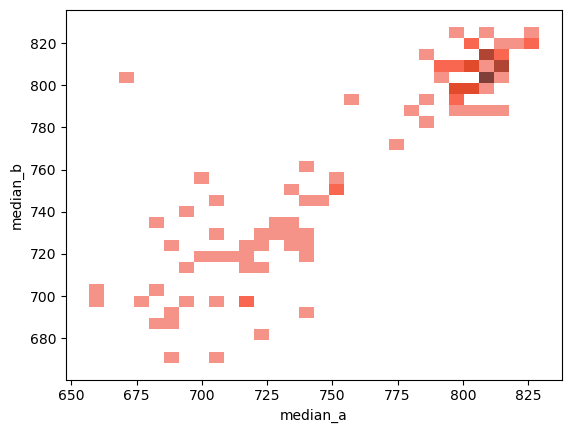

In [136]:
sns.histplot(data=df_cv, x='median_a', y='median_b', bins=30)

In [132]:
# wh = A

# bpv = iou.get_boxplot_values(wh)
# wh = wh.drop(wh[wh<=bpv['low_whisker']].index)

ix_a = A[A<iou.get_boxplot_values(A)['low_whisker']].index
ix_b = B[B<iou.get_boxplot_values(B)['low_whisker']].index

drop_indx = np.unique(ix_a.append(ix_b))

A = A.drop(drop_indx) 
B = B.drop(drop_indx) 

print(A)
print(B)


0        0.001102
1        0.001273
2        0.001844
3        0.001253
4        0.001384
           ...   
88296    0.001864
88297    0.001520
88298    0.001486
88299    0.000973
88300    0.001418
Name: gradlat_0, Length: 88183, dtype: float64
0        0.001281
1        0.001141
2        0.001837
3        0.000994
4        0.001355
           ...   
88296    0.001790
88297    0.001242
88298    0.001449
88299    0.000987
88300    0.000937
Name: gradlat_1, Length: 88183, dtype: float64


### LAT/CV visualisations 
|            | Observation A | Observation B | Comparison together | CV histograms              |
|------------|---------------|---------------|---------------------|----------------------------|
| Intra (X)  | Map A         | Map B         | Map - Both          | overlapped histogram (A/B) |
| Intra (Y)  | Map A         | Map B         | Map - Both          | overlapped hist            |
| Inter (X)  | ...           | ...           | ...                 | ...                        |
| Inter (Y)  | ...           | ...           | ...                 | ...                        |

1. Get mapping file
2. Create vtk files for A, B observations using Mapping information
3. Create 10 thresholds per case 
4. Create images 
   1. Manually on paraview, or 
   2. automatically (`vtkContourFilter`) 
> then, for the last column try 
5. Load CV for both cases 
6. use `sns.histplot()` to create overlapping histogram representations, could be 2D histogram
7. Assemble in graphic 

In [ ]:
intra_comparisons = 